# Jet Tagging with Graph Neural Networks (GNN)

This notebook shows how to use a GNN for jet classification between QCD and TT jets using particle-level features represented as a graph. Note that you get some GPU time on Kaggle for free (30 hrs/week). This will make training the model here faster, but note that it won't help you with the graph building, which also does take time here. Sadly you can't turn it on just to run the training, the notebook session must be run as either CPU or GPU. If you want to experiment with GNNs and the graph building becomes annoying, just save the graphs, and then load them as you need. 

## What is a GNN?
A Graph Neural Network (GNN) is a type of neural network designed to process graph-structured data. It can learn from both node features and the graph structure. It can be used to predict information about nodes, links between nodes or graphs as a whole. 

## Why use GNNs for Jet Tagging?
- Very flexible, can start from images or dataframes, or use both 
- Has the potential to remove areas where there is no energy deposited
- Has the potential to include long range interactions in a way a CNN can't 
- Can handle variable number of particles

## 1. Load and Prepare Data

We will create the graphs from images, but there are many other ways to do it. 

The energy deposited in a pixel will be the node feature, and we will connect each pixel to its eight closest pixels (up, down, sides, diagonals). 

The graph building function written here has an option to set max_nodes, which will only choose the top n most energetic nodes. There's also an option whether to consider all nodes or not, if you set this to false, it will throw away all the pixels with 0 energy deposited. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from torch_geometric.data import Data, DataLoader
import sys
sys.path.append('..')
from utils.data_processing import load_images
from utils.data_processing import create_graph_data
from utils.data_processing import load_processed_data 
from utils.plotting import plot_confusion_matrix, plot_training_history, plot_roc_curve


In [2]:
# Load data
X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids = load_images()

# Convert to graph format - this might take a bit of time to run 
X_train_graphs = create_graph_data(X_train, y_train, max_nodes=900, consider_all_nodes=True)
X_val_graphs = create_graph_data(X_val, y_val, max_nodes=900)
X_test_graphs = create_graph_data(X_test, max_nodes=900)


Created 3520 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Created 502 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Created 1005 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0


In [3]:
# Load global data
X_train_glob, y_train_glob, train_ids_glob, X_val_glob, y_val_glob, val_ids_glob, X_test_glob, test_ids_glob = load_processed_data()
X_train_glob.shape 

(3520, 14)

In [56]:
first_row = X_train_glob.head(2)
print(first_row)

   n_clusters  max_cluster_pt  mean_cluster_pt  std_cluster_pt  \
0          13             2.0         0.615318        0.539951   
1          10             2.0         0.777020        0.601157   

   max_cluster_size  mean_cluster_size  std_cluster_size  total_pt  \
0                 2                2.0               0.0  7.999129   
1                 2                2.0               0.0  7.770204   

   max_cluster_eta  max_cluster_phi  mean_cluster_eta  mean_cluster_phi  \
0              0.5              0.7          0.076923          0.346154   
1              0.2              0.5          0.100000          0.230000   

   cluster_pt_ratio  cluster_size_ratio  
0          1.470200                 1.0  
1          1.430785                 1.0  


In [17]:
print(X_val_graphs[0])

Data(x=[900, 1], edge_index=[2, 7332], y=1.0)


In [4]:
X_train_global_tensor = torch.tensor(X_train_glob.values, dtype=torch.float)
X_val_global_tensor = torch.tensor(X_val_glob.values, dtype=torch.float)
X_test_global_tensor = torch.tensor(X_test_glob.values, dtype=torch.float)

for i, data in enumerate(X_train_graphs):
    data.global_features = X_train_global_tensor[i]

for i, data in enumerate(X_val_graphs):
    data.global_features = X_val_global_tensor[i]

for i, data in enumerate(X_test_graphs):
    data.global_features = X_test_global_tensor[i]

In [5]:
print(X_train_graphs[0].global_features)          # A single tensor
print(X_train_graphs[0].global_features.shape)  

tensor([13.0000,  2.0000,  0.6153,  0.5400,  2.0000,  2.0000,  0.0000,  7.9991,
         0.5000,  0.7000,  0.0769,  0.3462,  1.4702,  1.0000])
torch.Size([14])


In [6]:
for i, data in enumerate(X_train_graphs[:3]):
    print(i, data.global_features.shape)

0 torch.Size([14])
1 torch.Size([14])
2 torch.Size([14])


## 2. Build GNN Model

We'll create a GNN with:
- Graph Convolutional layers to learn from node features and graph structure
- Global pooling to get graph-level representations
- Dense layers for classification

In [7]:
class GNN(nn.Module):
    def __init__(self, num_node_features, num_global_features):
        super(GNN, self).__init__()
        # # Graph convolution layers
        # self.conv1 = GCNConv(num_features, 64)
        # self.conv2 = GCNConv(64, 32)

        # Graph attention layers
        self.conv1 = GATConv(num_node_features, 32, heads=2, concat=True)
        self.conv2 = GATConv(64, 16, heads=2, concat=True)
        self.conv3 = GATConv(32, 16, heads=1, concat=True)
        
        # Dense layers
        self.fc1 = nn.Linear(16 + num_global_features, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        global_feat = data.global_features  # shape: [num_graphs, num_global_features]
        
        # Graph convolution layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        
        # Global pooling
        x = global_mean_pool(x, batch)

        if global_feat.dim() == 1:
            global_feat = global_feat.unsqueeze(0)

        print(f"x shape: {x.shape}, global_feat shape: {global_feat.shape}")

        # Concatenate global features
        x = torch.cat([x, global_feat], dim=1)  # shape: [num_graphs, 16 + num_global_features]
        
        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return torch.sigmoid(x)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNN(num_node_features=1, num_global_features=14).to(device)  # 4 features: pt, eta, phi, charge
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [8]:
train_loader = DataLoader(X_train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(X_val_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(X_test_graphs, batch_size=32)

/srv/conda/envs/notebook/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 3. Train Model

We'll train the GNN with:
- Adam optimizer
- Binary Cross Entropy loss
- Early stopping based on validation accuracy


You'll see this code differs a fair bit from the previous DNN and CNN. This is because we're using pytorch geometric -  the most common GNN package. It integrates with Pytorch, so we are using Pytorch instead of keras. Torch is growing to be the most popular ML libary, but keras is easier to learn. 

You might also see that training on CPU this is a lot slower than the other ML methods. Can you explain why? 

In [9]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.to(device))
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.to(device))
        loss = criterion(out, data.y.view(-1, 1))
        pred = (out > 0.5).float()
        correct += int((pred == data.y.view(-1, 1)).sum())
    return correct / len(loader.dataset), loss


history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}


# Training loop
best_acc = 0
for epoch in range(70):
    loss = train()
    train_acc = test(train_loader)[0]
    val_acc, val_loss = test(val_loader)
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')


    # Append to history
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

x shape: torch.Size([32, 16]), global_feat shape: torch.Size([1, 448])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 1 for tensor number 1 in the list.

## 4. Evaluate Model

Let's evaluate our model's performance on the test set.

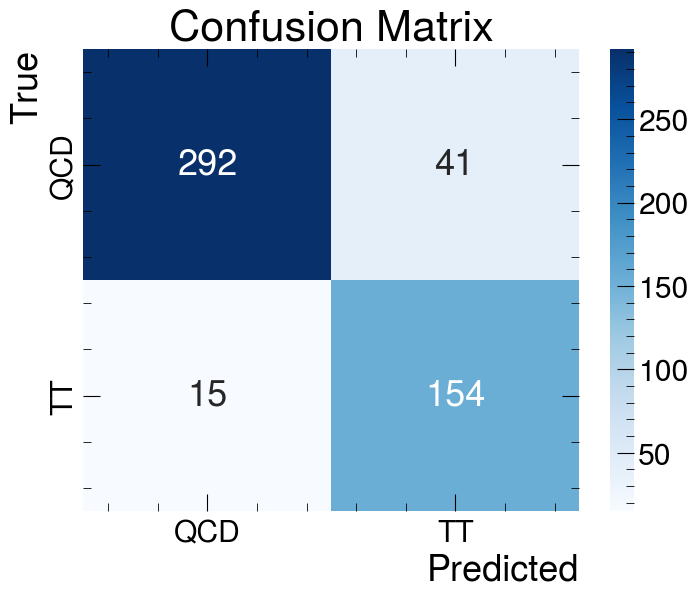

In [40]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad(): 
    for data in val_loader:
        out = model(data.to(device))
        y_true.extend(data.to('cpu').y.numpy())
        y_pred.extend(out.to('cpu').numpy())

y_pred = np.array([x[0] for x in y_pred])
pred_discrete = np.where(y_pred > 0.5, 1, 0)
# Plot confusion matrix
plot_confusion_matrix(y_true, pred_discrete)

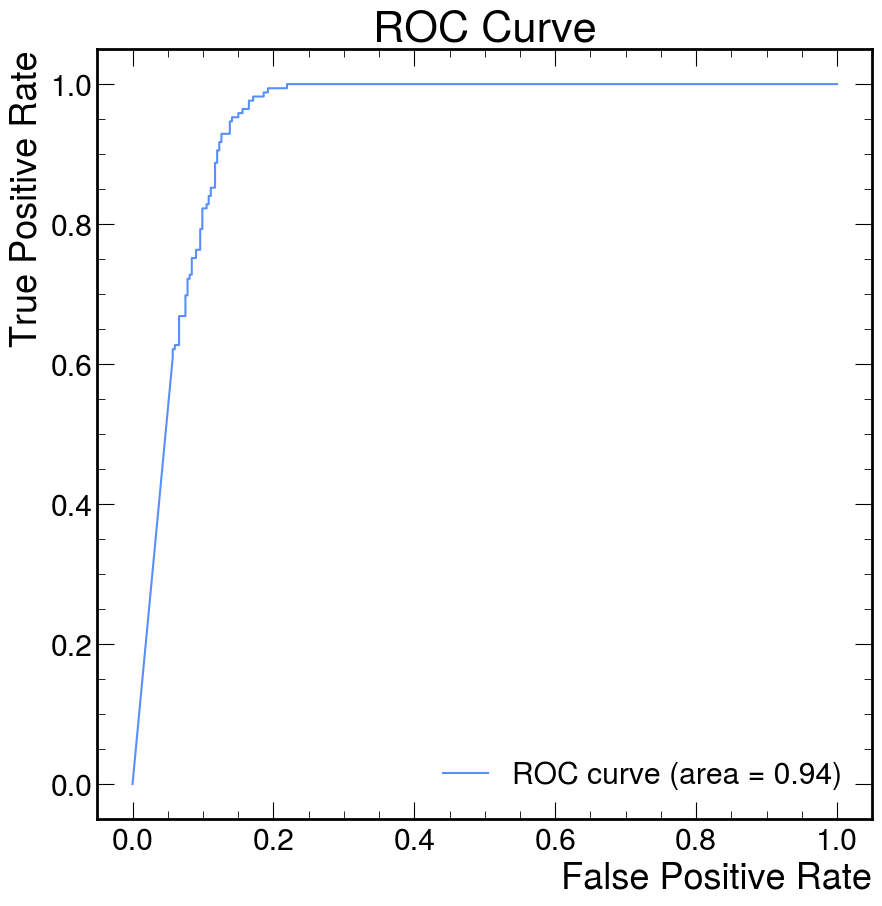

In [44]:
plot_roc_curve(y_true, y_pred)

# 5 - Making predictions

In [42]:
y_pred_test = []
for data in test_loader:
    with torch.no_grad():
        output = model(data.to(device))
        # could you change the prediction threshold? Would that make it better?
        y_pred_test.extend(output.to('cpu').numpy())

y_pred_test = np.array([x[0] for x in y_pred_test])


In [43]:
import pandas as pd
solution = pd.DataFrame({'id':test_ids, 'label':y_pred_test})
solution.to_csv('solution.csv', index=False)